In [1]:
%matplotlib inline
import sys
sys.path.append("..")

# DeepTrack 2.0 - Tracking multiple particles with a U-net

This tutorial demonstrates how to track multiple particles using a U-net with DeepTrack 2.0.

The U-net receives as input an image that may or may not contain particles and outputs an image whose pixels represent the probability that there is a particle nearby. Specifically, each pixel has a value between 0 (high confidence that there is no particle close by) and 1 (high confidence that there is a nearby particle).

This tutorial should be perused after the tutorials [deeptrack_introduction_tutorial](deeptrack_introduction_tutorial.ipynb) and [tracking_particle_cnn_tutorial](tracking_particle_cnn_tutorial.ipynb).

## 1. Setup

Imports needed for this tutorial.

In [2]:
import deeptrack as dt

import numpy as np
import matplotlib.pyplot as plt

imsize = 64 

## 2. Define the particle

For this example, we consider point particles (point light scatterers). A point particle is an instance of the class `PointParticle`, defined by its intensity and its position. Here, the position is randomized using a lambda function. More details can be found in the tutorial [tracking_particle_cnn_tutorial](tracking_particle_cnn_tutorial.ipynb).

In [38]:
class Rectangle(dt.Scatterer):
    def get(self, *inp, width, height, **kwargs):
            return np.ones((round(width), round(height), 1))
        
commons = dt.DummyFeature(
    image_size=imsize,
    position=lambda image_size: image_size / 2 + np.random.randn(2) * 2
)

        
particles = {
    "dumbbell":dt.Sphere(radius=1e-6, position=commons.position - (9, 0)) &  dt.Sphere(radius=1e-6, position=commons.position + (9, 0)),
    "large_sphere": dt.Sphere(radius=1e-6, position=commons.position),
    "small_sphere": dt.Sphere(radius=0.5e-6, position=commons.position),
    "large_ellipse": dt.Ellipse(radius=(1e-6, 2e-6), position=commons.position),
    "small_ellipse": dt.Ellipse(radius=(0.75e-6, 1e-6), position=commons.position),
#     "random_ellipse": dt.Ellipse(radius=0.5e-6 + np.random.rand(2) * 1.5e-6),
    "large_square":Rectangle(width=25, height=25, position=commons.position),
    "small_square":Rectangle(width=15, height=15, position=commons.position),
    "large_rectangle":Rectangle(width=17, height=27, position=commons.position),
    "small_rectangle":Rectangle(width=13, height=18, position=commons.position),
    
#     "random_square":Rectangle(width=lambda: 5 + np.random.rand() * 15, height=lambda width: width, position=commons.position),
#     "rectangle":Rectangle(width=15, height=30, position=commons.position),
#     "random_rectangle":Rectangle(width=lambda: 10 + np.random.rand() * 15, height=lambda: 5 + np.random.rand() * 15, position=commons.position),
    
}

## 3. Define the optical system 

Next, we need to define the properties of the optical system. This is done using an instance of the class `Fluorescence`, which takes a set of light scatterers (particles) and convolves them with the pupil function (point spread function) of the optical system. More details can be found in the tutorial [tracking_particle_cnn_tutorial](tracking_particle_cnn_tutorial.ipynb).

In [39]:
fluorescence_microscope = dt.Fluorescence(
    NA=0.8,                
    resolution=1e-6,     
    magnification=10,
    wavelength=680e-9,
    output_region=(0, 0, imsize, imsize)
)

## 4. Define noises

We introduce two sources of noise (see also [noises_example](../examples/noises_example.ipynb)):
1. A background random offset between 0 and 1.
2. A Poisson noise with a random SNR between 3 and 10.

In [40]:
poisson_noise = dt.Poisson(
    snr=lambda: np.random.rand()*7 + 20,
    background=0.1
)

## 5. Define the image features

We want images with a random number of particles between 1 and 10, a background offset, and Poisson noise.

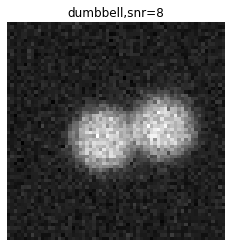

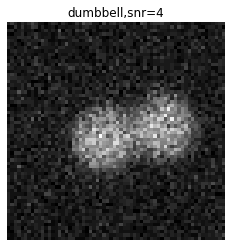

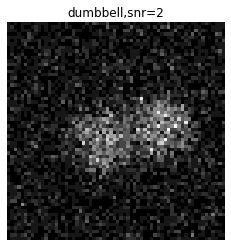

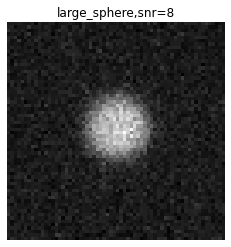

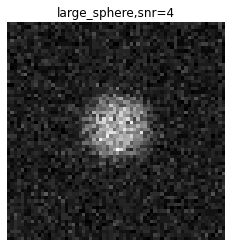

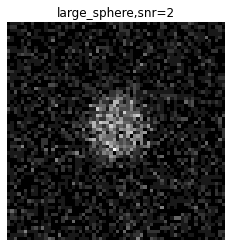

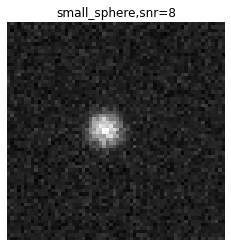

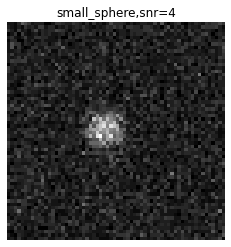

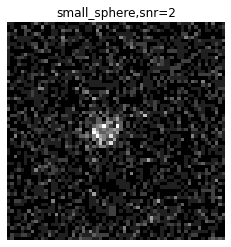

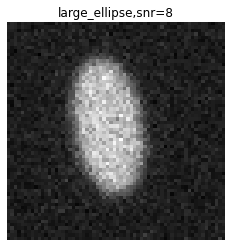

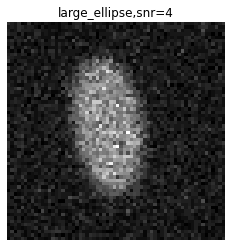

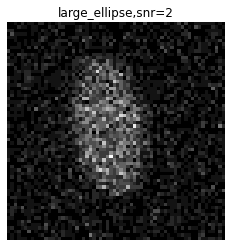

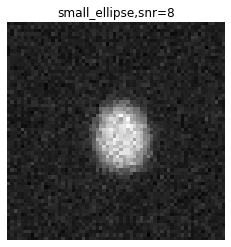

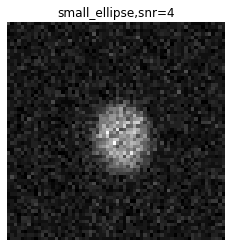

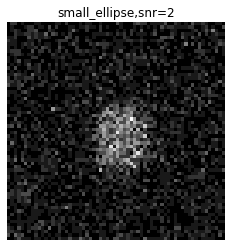

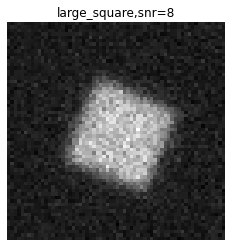

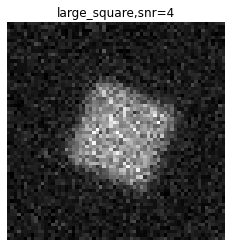

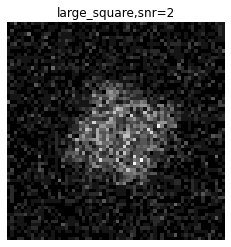

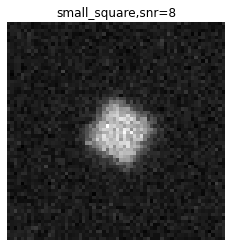

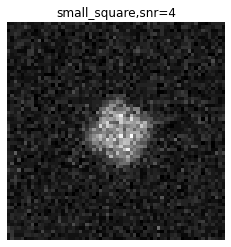

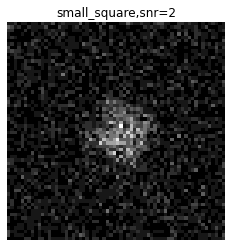

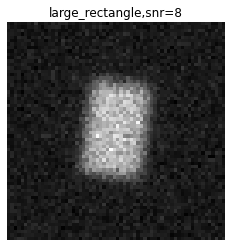

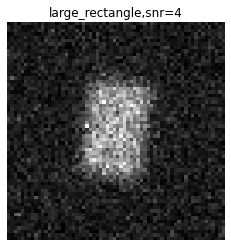

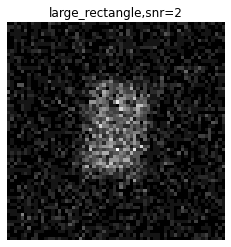

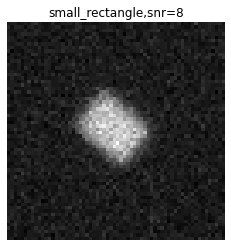

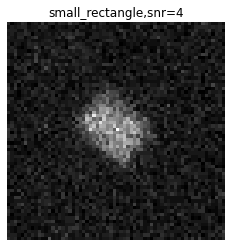

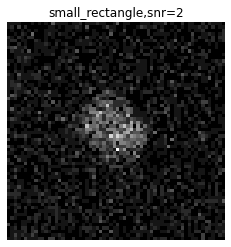

In [41]:
num_particles = lambda: 1
arguments = dt.Arguments(
    noise_level=5
)


pipelines = {}
for key, particle in particles.items():
    
    pipeline = (
        fluorescence_microscope(particle)
        >> dt.Affine(rotate=lambda:np.random.rand() * 2 * np.pi)
        >> dt.NormalizeMinMax() 
        + 0.2
    ) >> dt.Poisson(snr=arguments.noise_level, background=0.2) >> dt.NormalizeMinMax()
    
    pipeline.bind_arguments(arguments)
    pipeline.update()
    for noise_level in [8, 4, 2]:
        
        f = dt.Bind(pipeline, noise_level=noise_level)
        name = key + f",snr={noise_level}"
        
        example = f()
        
        plt.imshow(example, cmap="gray")
        plt.title(name)
        plt.axis("off")
        plt.show()
        
        
        pipelines[name] = f 
        

## 9. Define the neural network model

The neural network architecture used is a U-Net, which is a fully convolutional model used for image-to-image transformations. We create this model by calling the function `unet` (see also [models_example](../examples/models_example.ipynb)).

Since the desired output is a binary image, we will be using crossentropy as loss. Furthermore, since the target image is disproportionaly populated by 0s (any pixel is much more likely to be a zero than a one), we weight the loss such that false negatives are penalized ten times more than the false positives. 

The model can be customized by passing the following arguments:

* `input_shape`: Size of the images to be analyzed. The first two values can be set to `None` to allow arbitrary sizes.

* `conv_layers_dimensions`: Number of convolutions in each convolutional layer during down-
    and upsampling.
    
* `base_conv_layers_dimensions`: Number of convolutions in each convolutional layer at the base
    of the unet, where the image is the most downsampled.

* `output_conv_layers_dimensions`: Number of convolutions in each convolutional layer after the
    upsampling.
    
* `steps_per_pooling`: Number of convolutional layers between each pooling and upsampling
    step.

* `number_of_outputs`: Number of convolutions in output layer.

* `output_activation`: The activation function of the output.

* `loss`: The loss function of the network.

* `optimizer`: The the optimizer used for training.

* `metrics`: Additional metrics to evaulate during training.

## 10. Train the model

The model is trained by calling `.fit()`. This will take a few minutes.

In [42]:
datasets = {}
for name, pipeline in pipelines.items():
    print("Creating dataset for", name)
    dataset = [pipeline.update().resolve() for _ in range(500)]
    dataset_labels = [np.mean(d.get_property("position", get_one=False), axis=0) - imsize/2 for d in dataset]
    datasets[name] = (dataset, dataset_labels)

Creating dataset for dumbbell,snr=8
Creating dataset for dumbbell,snr=4
Creating dataset for dumbbell,snr=2
Creating dataset for large_sphere,snr=8
Creating dataset for large_sphere,snr=4
Creating dataset for large_sphere,snr=2
Creating dataset for small_sphere,snr=8
Creating dataset for small_sphere,snr=4
Creating dataset for small_sphere,snr=2
Creating dataset for large_ellipse,snr=8
Creating dataset for large_ellipse,snr=4
Creating dataset for large_ellipse,snr=2
Creating dataset for small_ellipse,snr=8
Creating dataset for small_ellipse,snr=4
Creating dataset for small_ellipse,snr=2
Creating dataset for large_square,snr=8
Creating dataset for large_square,snr=4
Creating dataset for large_square,snr=2
Creating dataset for small_square,snr=8
Creating dataset for small_square,snr=4
Creating dataset for small_square,snr=2
Creating dataset for large_rectangle,snr=8
Creating dataset for large_rectangle,snr=4
Creating dataset for large_rectangle,snr=2
Creating dataset for small_rectangle,

In [43]:
from deeptrack.extras.radialcenter import radialcenter

metric = lambda x, y: np.sqrt(np.sum(np.square(x - y)))

for name, dataset in datasets.items():
    Y = np.array([np.array(radialcenter(np.array(x), invert_xy=True)) - imsize/2 for x in dataset[0]]) 
    error = [metric(y, l) for y, l in zip(Y, dataset[1])]
    error = np.mean(error)
    print(f"Radialcenter on {name}: \t {error}")

Radialcenter on dumbbell,snr=8: 	 0.43687795003026353
Radialcenter on dumbbell,snr=4: 	 0.8160404735354239
Radialcenter on dumbbell,snr=2: 	 1.3319145154863394
Radialcenter on large_sphere,snr=8: 	 0.2618325025046797
Radialcenter on large_sphere,snr=4: 	 0.7483890444230544
Radialcenter on large_sphere,snr=2: 	 1.3955630120941551
Radialcenter on small_sphere,snr=8: 	 0.2255306291350685
Radialcenter on small_sphere,snr=4: 	 0.7557129672070687
Radialcenter on small_sphere,snr=2: 	 1.5207081357585552
Radialcenter on large_ellipse,snr=8: 	 0.35356246827456866
Radialcenter on large_ellipse,snr=4: 	 0.6784280889118062
Radialcenter on large_ellipse,snr=2: 	 1.1072348901764257
Radialcenter on small_ellipse,snr=8: 	 0.22889348718699842
Radialcenter on small_ellipse,snr=4: 	 0.6664151760823984
Radialcenter on small_ellipse,snr=2: 	 1.273258080898841
Radialcenter on large_square,snr=8: 	 0.3082589344834547
Radialcenter on large_square,snr=4: 	 0.6785459570506521
Radialcenter on large_square,snr=2:

In [44]:
import random

def get_accuracy_matrix(
    training_set_size=1, 
    metric=lambda x, y: np.sqrt(np.sum(np.square(x - y)))
):
    
    models = {}
    
    names = list(datasets.keys())
    
    score = np.zeros((len(names), len(names)))
    
    for name, dataset in datasets.items():
        
        dataset, dataset_labels = dataset
        
        print("Training for", name)
        model = dt.models.AutoTracker(
            input_shape=(imsize, imsize, 1),
        )
        
        training_pipeline = dt.Value(
            value=lambda:random.choice(dataset[:training_set_size])
        )
        
#         generator
        
        model.fit(training_pipeline, batch_size=8, epochs=30)
        
        models[name] = model
        
        for other, other_data in datasets.items():
            
            Y = model.predict(np.array(other_data[0]))
            
            error = [metric(y, l) for y, l in zip(Y, other_data[1])]
            error = error[training_set_size:]
            error = np.mean(error)
            
            
            i = names.index(name)
            j = names.index(other)
            
            score[i, j] = error
        print(score[i, :])
        plt.imshow(score, vmin=0, vmax=1)
        plt.colorbar()
        plt.show()
            
    return score, models
        

Training for dumbbell,snr=8
Generating 800 / 400 samples before starting training
Epoch 1/30
800/800 [==============================] - 9s 11ms/step - loss: 2.8632
Epoch 2/30
800/800 [==============================] - 9s 11ms/step - loss: 0.1316
Epoch 3/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0545
Epoch 4/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0461
Epoch 5/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0213
Epoch 6/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0366
Epoch 7/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0292
Epoch 8/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0323
Epoch 9/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0221
Epoch 10/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0193
Epoch 11/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0258
Epoch 12/30
80

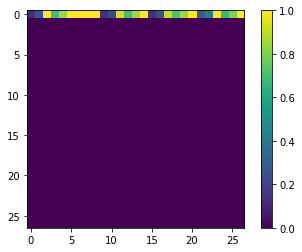

Training for dumbbell,snr=4
Generating 800 / 400 samples before starting training
Epoch 1/30
800/800 [==============================] - 9s 11ms/step - loss: 2.0635
Epoch 2/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0695
Epoch 3/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0512
Epoch 4/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0443
Epoch 5/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0384
Epoch 6/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0229
Epoch 7/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0288
Epoch 8/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0205
Epoch 9/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0399
Epoch 10/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0113
Epoch 11/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0187
Epoch 12/30
80

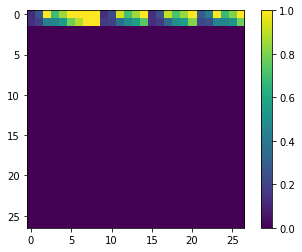

Training for dumbbell,snr=2
Generating 800 / 400 samples before starting training
Epoch 1/30
800/800 [==============================] - 9s 11ms/step - loss: 3.2412
Epoch 2/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0766
Epoch 3/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0454
Epoch 4/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0338
Epoch 5/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0325
Epoch 6/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0288
Epoch 7/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0337
Epoch 8/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0248
Epoch 9/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0286
Epoch 10/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0217
Epoch 11/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0190
Epoch 12/30
80

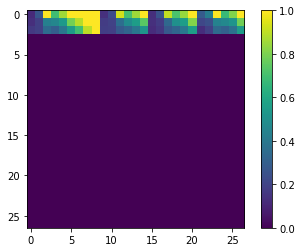

Training for large_sphere,snr=8
Generating 800 / 400 samples before starting training
Epoch 1/30
800/800 [==============================] - 9s 11ms/step - loss: 1.3327
Epoch 2/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0326
Epoch 3/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0183
Epoch 4/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0275
Epoch 5/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0099
Epoch 6/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0218
Epoch 7/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0083
Epoch 8/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0158
Epoch 9/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0078
Epoch 10/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0162
Epoch 11/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0065
Epoch 12/3

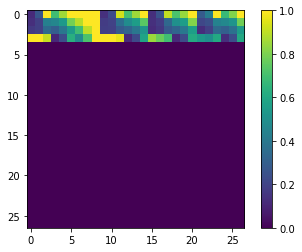

Training for large_sphere,snr=4
Generating 800 / 400 samples before starting training
Epoch 1/30
800/800 [==============================] - 9s 11ms/step - loss: 1.9521
Epoch 2/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0234
Epoch 3/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0270
Epoch 4/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0127
Epoch 5/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0173
Epoch 6/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0123
Epoch 7/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0150
Epoch 8/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0083
Epoch 9/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0108
Epoch 10/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0095
Epoch 11/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0182
Epoch 12/3

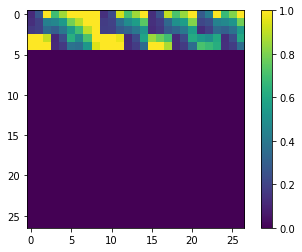

Training for large_sphere,snr=2
Generating 800 / 400 samples before starting training
Epoch 1/30
800/800 [==============================] - 9s 11ms/step - loss: 2.1602
Epoch 2/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0652
Epoch 3/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0276
Epoch 4/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0237
Epoch 5/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0191
Epoch 6/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0229
Epoch 7/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0190
Epoch 8/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0199
Epoch 9/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0196
Epoch 10/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0173
Epoch 11/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0144
Epoch 12/3

In [ ]:
score_1, models_1 = get_accuracy_matrix(1)
score_100, models_100 = get_accuracy_matrix(100)


0.29278165190578714
0.5552852676817531


In [ ]:
score_100

In [ ]:
[0.18317655 0.09671017 0.08064314]
[0.22469646 0.09257973 0.06540189]
[0.25455001 0.10288141 0.07503905]

predictions = model.predict(np.array(dataset))

dataset_labels = np.array([[*d.get_property("position") - imsize/2, d.get_property("rotate")]  for d in dataset])

err = predictions - dataset_labels[:, :2]

plt.scatter(dataset_labels[:, 2], err[:, 0])
plt.show()
plt.scatter(dataset_labels[:, 2], err[:, 1])

In [ ]:
metric = lambda x, y: x - y

error = np.array([metric(y, l) for y, l in zip(Y, dataset[1])])

plt.plot(error[:, 0])
plt.plot(error[:, 1])

In [ ]:
x = image_features.update().resolve()

out = model.predict(x[np.newaxis])[0]

plt.subplot(1, 4, 1)
plt.imshow(x)
plt.subplot(1, 4, 2)
plt.imshow(out[..., 0])
plt.subplot(1, 4, 3)
plt.imshow(out[..., 1])
plt.subplot(1, 4, 4)
plt.imshow(out[..., 2])
plt.show()

In [ ]:
x

## 11. Visualize the model performance

Finally, we evaluate the model performance by showing the model output besides the input image and the target image.

In [ ]:
# generator[0] grabs a single batch from the generator
input_image, target_image = generator[0]

for i in range(input_image.shape[0]):
    
    predicted_image = model.predict(input_image)
    plt.figure(figsize=(15, 5))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(input_image[i, :, :, 0]), cmap="gray")
    plt.title("Input Image")

    plt.subplot(1,3,2)
    plt.imshow(np.squeeze(predicted_image[i, :, :, 0]), cmap="gray")
    plt.title("Predicted Image")
    
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(target_image[i, :, :, 0] > 0.5), cmap="gray")
    plt.title("Target image")

    plt.show()

In [ ]:
import tensorflow as tf
import tensorflow_addons
from deeptrack.losses import softmax
K = tf.keras.backend

P = np.ones((2, 32, 32, 3), dtype=np.float32)
P[1] = -1
T = np.array([[1., 0, 0, 0, 1, 0, 0, 0], [-1, 0, 1, 0, -1, 1, 0, 0]], dtype=np.float32)


transform = K.reshape(T[:, :6], (-1, 2, 3))

offset_vector = transform[:, :, 2]
transformation_matrix = transform[:, :2, :2]

# For broadcasting

offset_vector = K.reshape(offset_vector, (-1, 1, 1, 2))
transformation_matrix = K.reshape(transformation_matrix, (-1, 1, 1, 2, 2))

# Transforms and broadcasts the
transformed_origin = tf.linalg.matvec(transformation_matrix, P[:1, ..., :2])

# Transforms all prediced images to match the first image
transformed_field = tensorflow_addons.image.transform(transformed_origin, T, fill_mode="wrap")

error = offset_vector - (P[..., :2] - transformed_field)

error_tot = (
    error
    * softmax(P[:, :, :, 2:3], axis=(1, 2, 3))
    * K.cast_to_floatx(K.shape(error)[1] * K.shape(error)[2])
)
# return error

In [ ]:
transformed_field.numpy()[1, ..., 1]